# STIRAP

In [1]:
# many more imports than are needed here

from physconsts import *
from rbconsts import *
from numpy import *
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # for fancy tick manipulation
from scipy.integrate import solve_ivp
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from time import time
from arc import *
from scipy.special import sph_harm as ylm
from scipy.stats import rv_continuous

# local
from amophys import *
from simfuncs import *

# other
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

#### layout stuff
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100% !important;}</style>"))

### TDSE three level model

No handles with labels found to put in legend.


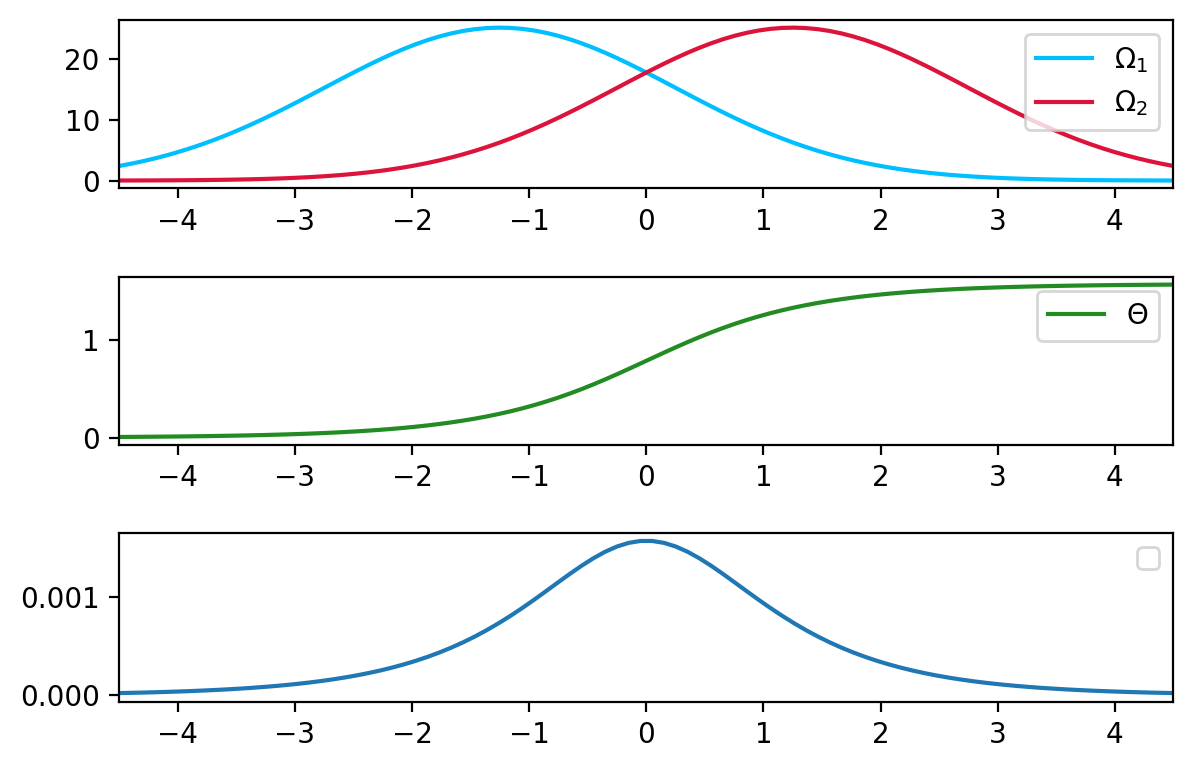

In [98]:
# check stirap condition

o1max = o2max = 8*pi # maximum ground<->rydberg rabi frequency, one atom
tmax = 5 # pi time for 2-atom g<->w Rabi frequency

tpts = linspace(-tmax,tmax,100)
w = 1.5 # pulse width
mu = 2.5 # pulse separation
o1 = lambda t: o1max*exp(-0.5*((t-0.5*mu)/w)**2)
o2 = lambda t: o2max*exp(-0.5*((t+0.5*mu)/w)**2)

fig,axes = plt.subplots(nrows=3,ncols=1,dpi=200)
fig.tight_layout()

# counter-intuitive pulse sequence
axes[0].plot(tpts,o2(tpts),color='deepskyblue',label='$\Omega_1$')
axes[0].plot(tpts,o1(tpts),color='crimson',label='$\Omega_2$')

# the mixing angle
bigtheta = lambda t: arctan2(o1(t),o2(t))
axes[1].plot(tpts,bigtheta(tpts),color='forestgreen',label='$\Theta$')

# stirap condition
stirap_cond = abs(gradient(bigtheta(tpts)))/sqrt(o1max**2 + o2max**2) # want << 1
axes[2].plot(tpts,stirap_cond)

for ax in axes:
    ax.set_xlim((-(tmax-0.5),tmax-0.5))
    ax.legend()

In [99]:
psi0 = array([1,0,0],complex)
d1 = d2 = 0
hfull = lambda t: array([[0,o1(t)/2,0],
                         [o1(t)/2,d1,o2(t)/2],
                         [0,o2(t)/2,d1-d2]],complex)
dpsi = lambda t,psi: -1j*dot(hfull(t),psi)
soln = solve_ivp(dpsi,[-tmax,tmax],psi0,t_eval=tpts,vectorized=True)

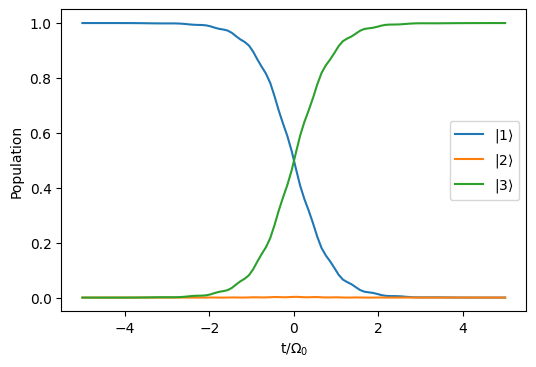

In [107]:
fig,ax = plt.subplots(dpi=100)
labels = [rf'$|{i}\rangle$'for i in range(1,4)]
# labels = [r'|outside garage$\rangle$',r'|doorway$\rangle$',r'|inside garage$\rangle$']
for y,l in zip(soln.y,labels):
    ax.plot(tpts,abs(y)**2,label=l)
ax.set_xlabel('t/$\Omega_0$')
ax.set_ylabel('Population')
ax.legend()

## STIRAP stretch-state optical pumping
loosely based on Mark's idea, only in that it uses STIRAP. 